In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import text
from  tensorflow.keras.preprocessing import sequence
import tensorflow_datasets as tfds
import numpy as np
import json
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
print("# of GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

# of GPUs: 1


# Tạo dữ liệu

## Download dữ liệu tfds

`load` is a convenience method that fetches the `tfds.core.DatasetBuilder` by
string name, optionally calls `DatasetBuilder.download_and_prepare`
(if `download=True`), and then calls `DatasetBuilder.as_dataset`.
This is roughly equivalent to:

```
builder = tfds.builder(name, data_dir=data_dir, **builder_kwargs)
if download:
  builder.download_and_prepare(**download_and_prepare_kwargs)
ds = builder.as_dataset(
    split=split, as_supervised=as_supervised, **as_dataset_kwargs)
if with_info:
  return ds, builder.info
return ds
```

In [ ]:
## Download dữ liệu:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [ ]:
# Kiểm tra loại dữ liệu của imdb:
imdb.__class__

dict

In [ ]:
imdb.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [ ]:
# Tạo tập train, valid:
train_ds, valid_ds = imdb['train'], imdb['test']

In [ ]:
train_ds.__class__

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
# Kiểm tra dữ liệu:
for s, l in train_ds.take(1):
    print(s)
    print(l)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
# Chuyển đổi dữ liệu sang dạng string:
train_sentences = []
train_labels = []
for s, l in train_ds:
    train_sentences.append(str(s.numpy())) # bổ sung từng câu dưới dạng string vào list
    train_labels.append(l.numpy()) # bổ sung nhãn dưới dạng số vào list
print(f'#{len(train_sentences)}:')
print(train_sentences[0])
print(train_labels[0])
print(f'Số lượng labels: {set(train_labels)}')

#25000:
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
Số lượng labels: {0, 1}


In [ ]:
# Làm tương tự với dữ liệu valid:
valid_sentences = []
valid_labels = []

for s, l in valid_ds:
    valid_sentences.append(str(s.numpy()))
    valid_labels.append(l.numpy())
print(f'#{len(valid_sentences)}:')
print(valid_sentences[0])
print(valid_labels[0])

#25000:
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
1


__Lưu ý:__
Như vây chúng ta đã có cả dữ liệu về train, valid, với cùng độ dài là 2500 câu. Và nhãn ở dạng binary (0, 1).

## Tokenize

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_len = 120
trunc_type = 'post'
oov_tok = 'UNK'
# Tạo tokenizer và fit dữ liệu train:
tokenizer = text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

# Tạo word_index, sequences, pad_sequences từ tập train:
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_sentences)
padded_sequences = sequence.pad_sequences(sequences, maxlen=max_len, padding='post', truncating=trunc_type)

# Tạo sequences, pad_sequences từ tập valid:
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
padded_valid_sequences = sequence.pad_sequences(valid_sequences, maxlen=max_len, padding='post', truncating=trunc_type)

In [ ]:
# Biến đổi dữ liệu:
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

# Tạo Wordembedding Model

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len)
    , keras.layers.Flatten()
    , keras.layers.Dense(6, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Đào tạo:
model.fit(padded_sequences, train_labels, batch_size=64, epochs=10, validation_data=(padded_valid_sequences, valid_labels))

Epoch 1/10
391/391 [==============================] - 12s 29ms/step - loss: 0.6913 - accuracy: 0.5174 - val_loss: 0.6522 - val_accuracy: 0.6823
Epoch 2/10
391/391 [==============================] - 13s 34ms/step - loss: 0.5617 - accuracy: 0.7741 - val_loss: 0.4251 - val_accuracy: 0.8134
Epoch 3/10
391/391 [==============================] - 11s 28ms/step - loss: 0.3379 - accuracy: 0.8685 - val_loss: 0.3796 - val_accuracy: 0.8317
Epoch 4/10
391/391 [==============================] - 10s 27ms/step - loss: 0.2483 - accuracy: 0.9117 - val_loss: 0.3835 - val_accuracy: 0.8288
Epoch 5/10
391/391 [==============================] - 10s 25ms/step - loss: 0.1911 - accuracy: 0.9404 - val_loss: 0.3852 - val_accuracy: 0.8308
Epoch 6/10
391/391 [==============================] - 13s 33ms/step - loss: 0.1446 - accuracy: 0.9624 - val_loss: 0.4056 - val_accuracy: 0.8247
Epoch 7/10
391/391 [==============================] - 11s 29ms/step - loss: 0.1059 - accuracy: 0.9796 - val_loss: 0.4259 - val_accuracy:

## Kiểm tra kết quả

In [ ]:
history = model.history

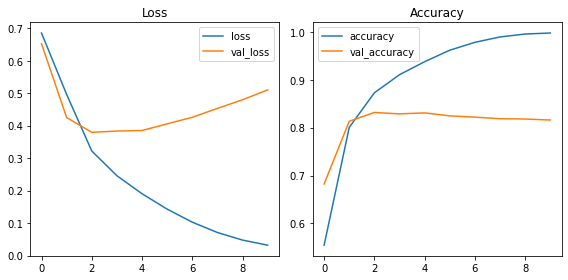

In [ ]:
figure = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['loss', 'val_loss'])
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.tight_layout()

Chúng ta có thể thấy, chỉ sau khoảng 4 epoch thì cả loss và accuracy của tập valid có dấu hiệu giảm về chất lượng (loss tăng, accuracy giảm).

## Word projector
> Chúng ta có thể lưu lại kết quả và sử dụng [tensorflow projector](https://projector.tensorflow.org/) để tìm các từ đồng nghĩa hoặc trái nghĩa nhau.

In [ ]:
embedding = model.layers[0]
embed_weights = embedding.get_weights()[0]
embed_weights.shape

(10000, 16)

In [ ]:
embed_weights[:5,:5]

array([[-0.03195839,  0.00646526,  0.05564664, -0.02617251, -0.04467828],
       [ 0.03657629, -0.04752545,  0.04951461,  0.00140271, -0.07202243],
       [ 0.00488849, -0.07538385,  0.05575233, -0.009174  , -0.09458886],
       [ 0.00895901, -0.08287876, -0.01504743, -0.08409293, -0.04379781],
       [ 0.02991377, -0.08056286,  0.00964941,  0.01967221, -0.05316688]],
      dtype=float32)

In [ ]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# index của từ điển bắt đầu từ 1:
for idx in range(1, vocab_size):
    word = tokenizer.sequences_to_texts([[idx]])[0] # sequences_to_texts có input là list và output là list, 
    #nên chúng ta phải để idx dưới dạng list và lấy idx position =0 cho output
    e_w = embed_weights[idx] ## lấy sequence weights của từng từ
    out_m.write(word + '\n') # ghi lại từ
    out_v.write('\t'.join([str(x) for x in e_w]) + '\n')
out_m.close()
out_v.close()  

Sau khi đã có được dữ liệu về từ và vector weights của các từ vs nhau (embedding_weights), chúng ta có thể load files lên projector để kiểm tra kết quả:
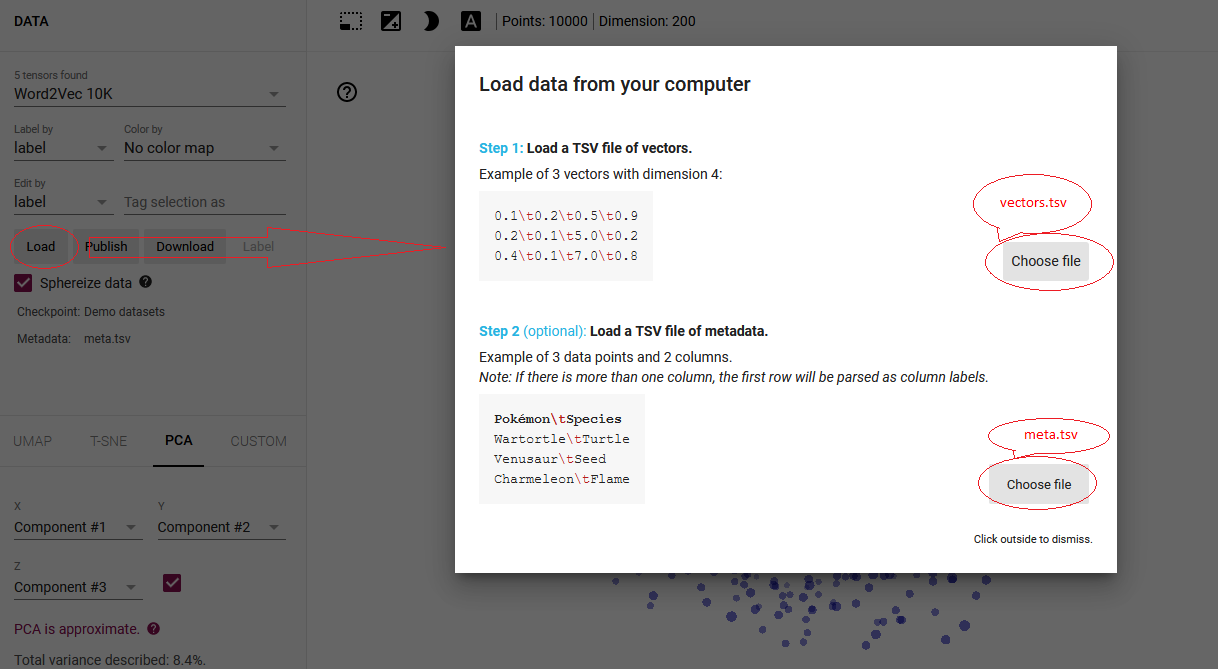

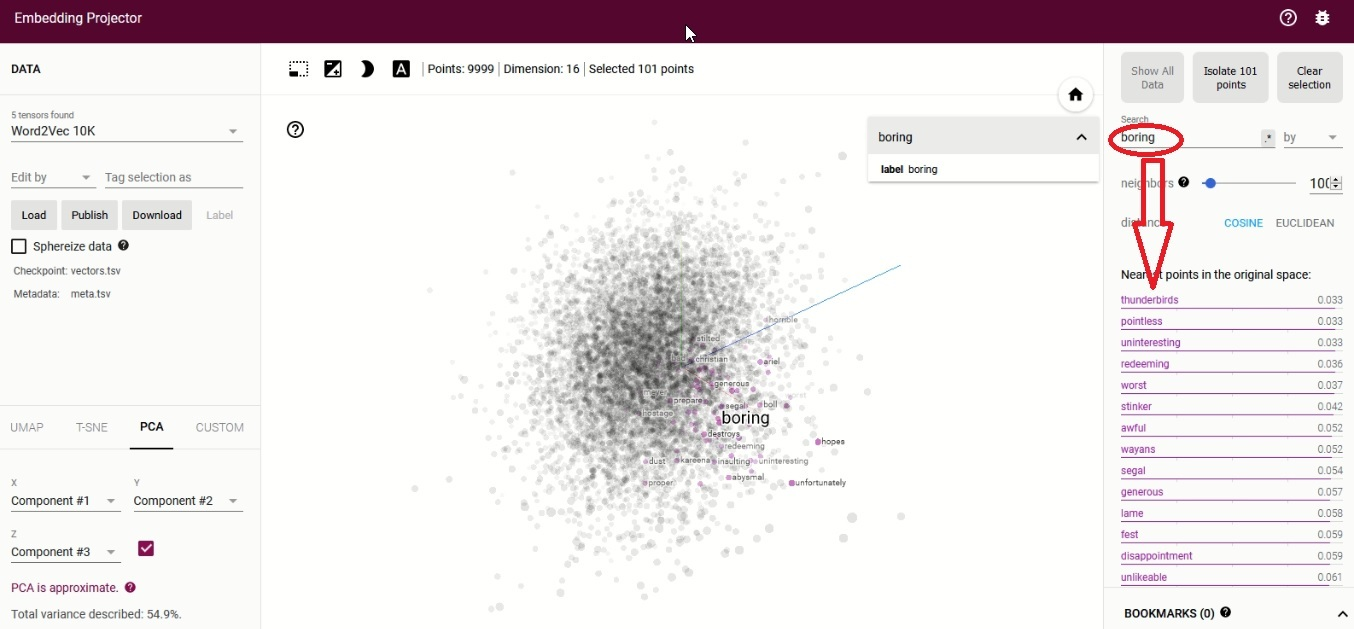

# Sarcasm Dataset

In [ ]:
sentences = []
labels = []
urls = []

file_name = '/home/ddpham/git/TFExam/data/Sarcasm_Headlines_Dataset.json'
file = open(file_name, 'r')
for line in file.readlines():
    line = json.loads(line)
    sentences.append(line['headline'])
    labels.append(line['is_sarcastic'])
    urls.append(line['article_link'])
file.close()

In [ ]:
print(f'#{len(sentences)}:\n{sentences[0]}, \n{labels[0]}, \n{urls[0]}')

#26709:
former versace store clerk sues over secret 'black code' for minority shoppers, 
0, 
https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5


## Tokenization

In [ ]:
num_words = 10000
embed_dim = 16
# max_len=20
trunc_type='post'
padding_type='post'
oov_token = 'UNK'
training_size = 20000

In [ ]:
train_sentences = sentences[:training_size]
valid_sentences = sentences[training_size:]
train_labels = np.array(labels[:training_size])
valid_labels = np.array(labels[training_size:])

In [ ]:
tokenizer = text.Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sentences = tokenizer.texts_to_sequences(train_sentences)
valid_sentences = tokenizer.texts_to_sequences(valid_sentences)

In [ ]:
# Chúng ta hay kiểm tra một chút về độ dài của tất cả các câu:
len_sentences = []
for i in train_sentences:
    len_sentences.append(len(i))
len_dict = dict.fromkeys(set(len_sentences), 0)
for length in len_sentences:
    len_dict[length] += 1
len_dict

{2: 85,
 3: 228,
 4: 380,
 5: 777,
 6: 1218,
 7: 1640,
 8: 2048,
 9: 2406,
 10: 2569,
 11: 2470,
 12: 2082,
 13: 1457,
 14: 1027,
 15: 638,
 16: 397,
 17: 267,
 18: 142,
 19: 63,
 20: 43,
 21: 24,
 22: 18,
 23: 8,
 24: 3,
 26: 2,
 27: 1,
 28: 1,
 29: 1,
 30: 2,
 31: 1,
 39: 1,
 40: 1}

<AxesSubplot:xlabel='len'>

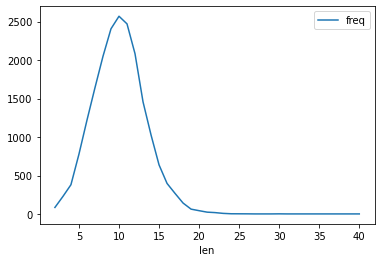

In [ ]:
# Vẽ đồ thị histogram về tần suất độ dài:
import pandas as pd
pd.DataFrame(list(len_dict.items()), columns=['len', 'freq']).plot('len', 'freq')

In [ ]:
# Padding:
train_sentences = sequence.pad_sequences(train_sentences, padding=padding_type, truncating=trunc_type)
valid_sentences = sequence.pad_sequences(valid_sentences, padding=padding_type, truncating=trunc_type)

In [ ]:
train_sentences.shape, valid_sentences.shape

((20000, 40), (6709, 38))

In [ ]:
train_sentences[5:10, 10:15]

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [150,   6,  33, 343,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=int32)

## Tạo model

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(num_words, embed_dim, input_length=max_len)
    , keras.layers.GlobalAveragePooling1D()
    , keras.layers.Dense(24, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n = 30
model.fit(train_sentences, train_labels, epochs=n, validation_data=(valid_sentences, valid_labels), verbose=2)

Epoch 1/30


625/625 - 14s - loss: 0.6439 - accuracy: 0.6220 - val_loss: 0.5460 - val_accuracy: 0.7779
Epoch 2/30
625/625 - 14s - loss: 0.4430 - accuracy: 0.8161 - val_loss: 0.4078 - val_accuracy: 0.8155
Epoch 3/30
625/625 - 15s - loss: 0.3514 - accuracy: 0.8505 - val_loss: 0.3842 - val_accuracy: 0.8275
Epoch 4/30
625/625 - 13s - loss: 0.3113 - accuracy: 0.8694 - val_loss: 0.3574 - val_accuracy: 0.8463
Epoch 5/30
625/625 - 12s - loss: 0.2866 - accuracy: 0.8806 - val_loss: 0.3543 - val_accuracy: 0.8496
Epoch 6/30
625/625 - 12s - loss: 0.2709 - accuracy: 0.8899 - val_loss: 0.3560 - val_accuracy: 0.8506
Epoch 7/30
625/625 - 14s - loss: 0.2597 - accuracy: 0.8925 - val_loss: 0.3638 - val_accuracy: 0.8481
Epoch 8/30
625/625 - 12s - loss: 0.2506 - accuracy: 0.9000 - val_loss: 0.3615 - val_accuracy: 0.8514
Epoch 9/30
625/625 - 12s - loss: 0.2439 - accuracy: 0.9021 - val_loss: 0.3612 - val_accuracy: 0.8530
Epoch 10/30
625/625 - 11s - loss: 0.2382 - accuracy: 0.9047 - val_loss: 0.3739 - val_accuracy: 0.8435


In [ ]:
history = model.history

In [ ]:
# Chúng ta muốn vẽ kết quả của lần train vừa rồi 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

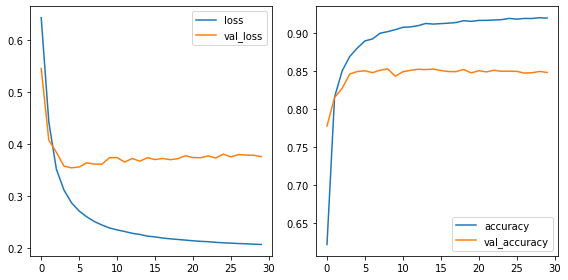

In [ ]:
# Sử dụng loop:
item_dict = {'Loss': ['loss', 'val_loss'], 'Accuracy': ['accuracy', 'val_accuracy']}
plot_list = ['Loss', 'Accuracy']
plt.figure(figsize=(8, 4))
for i in range(len(plot_list)):
    plt.subplot(1, 2, i+1)
    item = plot_list[i]
    for items in item_dict[item]:
        plt.plot(history.history[items])
    plt.legend(item_dict[item])
plt.tight_layout()

In [ ]:
# Tạo hàm plot:
def plot_history(history):
    item_dict = {'Loss': ['loss', 'val_loss'], 'Accuracy': ['accuracy', 'val_accuracy']}
    plot_list = ['Loss', 'Accuracy']
    plt.figure(figsize=(8, 4))
    for i in range(len(plot_list)):
        plt.subplot(1, 2, i+1)
        item = plot_list[i]
        for items in item_dict[item]:
            plt.plot(history.history[items])
        plt.legend(item_dict[item])
    plt.tight_layout()

__Lưu ý:__ 
Chúng ta có thể thấy được kết quả của việc train dữ liệu thông qua việc visualize loss và metric.

Nhìn vào đồ thị, chúng ta có thể thấy, chỉ với dưới 3 epochs, dữ liệu của tập validate đã có dấu hiện bị overfit khi cả giá trị loss và giá trị accuracy đều không có tiến triển.

## Tunning model
> Chúng ta thử thay đổi một vài hyper-parameters để xem kết quả của model có được cải thiện không.

In [ ]:
num_words = 1000 # giảm từ 10K
max_len = 20 # giảm từ 40
embed_dim = 15 # giảm từ 16
trunc_type = 'post'
pad_type = 'post'
oov_token = 'UNK'
training_size = 18000 # tăng size cho tập valid

In [ ]:
# Parse dữ liệu
sentences = []
labels = []
urls = []

file_name = '/home/ddpham/git/TFExam/data/Sarcasm_Headlines_Dataset.json'
file = open(file_name, 'r')
for line in file.readlines():
    line = json.loads(line)
    sentences.append(line['headline'])
    labels.append(line['is_sarcastic'])
    urls.append(line['article_link'])
file.close()

train_sentences = sentences[:training_size]
valid_sentences = sentences[training_size:]
train_labels = labels[:training_size]
valid_labels = labels[training_size:]

In [ ]:
# Tokenize & padding:
tokenizer = text.Tokenizer(num_words=num_words, oov_token=oov_token)
# dir(tokenizer)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

train_sequences = sequence.pad_sequences(train_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)
valid_sequences = sequence.pad_sequences(valid_sequences, maxlen=max_len, padding=pad_type, truncating=trunc_type)
# Kiểm tra shape:
train_sequences.shape, valid_sequences.shape

((18000, 20), (8709, 20))

### Tạo neural net mới

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(num_words, embed_dim, input_length=max_len)
    , keras.layers.GlobalAveragePooling1D()
    , keras.layers.Dense(24, activation='relu')
    , keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 15)            15000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                384       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 15,409
Trainable params: 15,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_sequences, train_labels, epochs=10, batch_size=32, validation_data=(valid_sequences, valid_labels))

Epoch 1/10
563/563 [==============================] - 9s 16ms/step - loss: 0.6345 - accuracy: 0.6229 - val_loss: 0.4231 - val_accuracy: 0.8105
Epoch 2/10
563/563 [==============================] - 9s 15ms/step - loss: 0.3935 - accuracy: 0.8230 - val_loss: 0.3987 - val_accuracy: 0.8173
Epoch 3/10
563/563 [==============================] - 9s 16ms/step - loss: 0.3640 - accuracy: 0.8336 - val_loss: 0.3959 - val_accuracy: 0.8180
Epoch 4/10
563/563 [==============================] - 9s 15ms/step - loss: 0.3503 - accuracy: 0.8422 - val_loss: 0.3967 - val_accuracy: 0.8171
Epoch 5/10
563/563 [==============================] - 9s 15ms/step - loss: 0.3445 - accuracy: 0.8445 - val_loss: 0.3986 - val_accuracy: 0.8155
Epoch 6/10
563/563 [==============================] - 9s 16ms/step - loss: 0.3504 - accuracy: 0.8414 - val_loss: 0.4089 - val_accuracy: 0.8107
Epoch 7/10
563/563 [==============================] - 9s 15ms/step - loss: 0.3489 - accuracy: 0.8420 - val_loss: 0.4024 - val_accuracy: 0.8116

In [ ]:
history = model.history

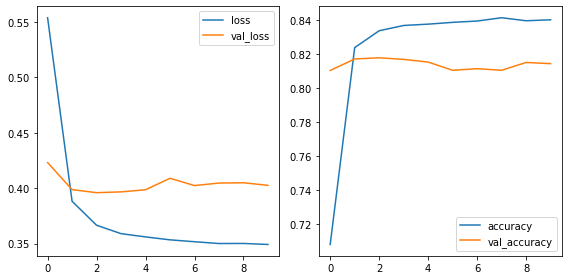

In [ ]:
# Visualize:
plot_history(history)

__NOTE:__
Chúng ta có thể thấy, mặc dù accuracy của valid giảm xuống tương đối (3%), nhưng mức độ overfit của model rõ ràng đã cải thiện đáng kể. Khoảng cách giữa train và valid đã thu hẹp tương đối nhiều (giảm > 2 lần) cho cả loss và accuracy.

Chúng ta có thể thử tiếp vs max_len=15, embed_dim=10 để kiểm tra model có cải thiện về mức độ overfit hay ko. Tất nhiên, khi chúng ta giảm chiều xuống thì sẽ ít hơn số lượng từ tương đồng hoặc đối lập nhau để có thể view được những từ có ý nghĩa hơn và những từ tương đồng hay đối lập thường sẽ rất hiển nhiên.

### Word projector
Tương tự như cách thức ở trên, hãy tạo ra vectors và weights để projects tương quan giữa các từ vs nhau:

In [ ]:
sarcasm_emb = model.layers[0]
sarcasm_weights = sarcasm_emb.get_weights()[0]
sarcasm_weights.shape

(1000, 15)

In [ ]:
sarc_meta = io.open('sarcasm_meta.tsv', 'w', encoding='utf-8')
sarc_vect = io.open('sarcasm_vectors.tsv', 'w', encoding='utf-8')

for idx in range(1, num_words):
    word = tokenizer.sequences_to_texts([[idx]])[0]
    weights = sarcasm_weights[idx]
    sarc_meta.write(word + '\n')
    sarc_vect.write('\t'.join([str(x) for x in weights]) + '\n')
sarc_meta.close()
sarc_vect.close()

# Giới thiệu về subword tokenizer
> Khác với tokenizer chúng ta biết ở trên, các từ được gán với id (dạng số nguyên dương) và được hợp thành sequences để đào tạo model. Tuy nhiên, với subword tokenizer, một từ có thể được tách ra nhỏ hơn.
> Phần này tạm thời dừng lại ở đây!